In [30]:
from qulacs import QuantumState, QuantumCircuit, Observable, PauliOperator
from qulacs.gate import X, Z, RX, RY, RZ, CNOT, merge, DenseMatrix, add, PauliRotation, H, S, Sdag
from qulacs.state import inner_product
import matplotlib.pyplot as plt
import numpy as np
from qulacsvis import circuit_drawer as draw
import seaborn as sns
sns.set_style("darkgrid")
from trotterization.utils import *

Target Hamiltonian:
$$
H = J\sum_{i=1}^n Z_i Z_{i+1} + h \sum_{i=1}^n X_i
$$

Define $\hat{U}_p$: p-th order Trotter-decomposed unitary.
When $p=1$,
$$
\hat{U}_1(t) = e^{\frac{t}{n} \hat{A}} e^{\frac{t}{n} \hat{B}}
$$
When $p=2$,
$$
\hat{U}_2(t) = e^{\frac{t}{2n} \hat{A}} e^{\frac{t}{n} \hat{B}} e^{\frac{t}{2n} \hat{A}}
$$
When $p=4$,
$$
\hat{U}_4(t) = \hat{U}_2^2(s_2 t) \cdot \hat{U}_2[(1 - 4s_2)t] \cdot \hat{U}_2^2(s_2 t), \, {\rm where }\, s_2 = 1/(4-\sqrt[3]{4})
$$

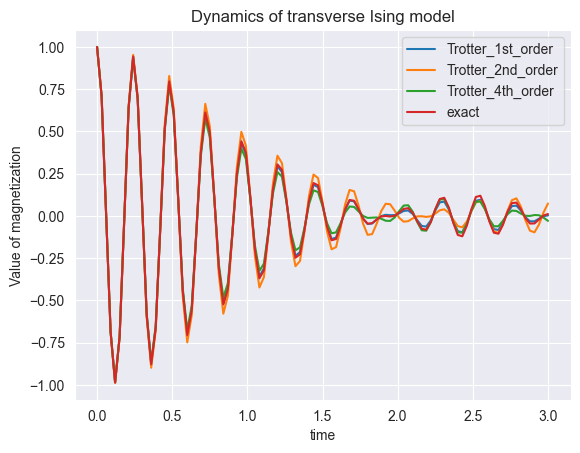

In [31]:
# number of qubits
nqubits = 6
# Simuation time
t = 3
# split count for Trotter decomposition
M = 1000
# time division for each step
delta = t / M

# strength of transverse field
coef_J = 1.0
coef_h = 3.0

use_cnot_gate = True # If True, pauli rotation gate is implemented with CNOT + 1qubit RZ gate
magnetization_obs = gen_observable(nqubits)

## Initial state |00...0>
state_trotter = QuantumState(nqubits)
state_trotter.set_zero_state()
state_exact = QuantumState(nqubits)
state_exact.set_zero_state()

# Step 0: calculate the exact solution
circuit_exact_transIsing = QuantumCircuit(nqubits)
time_evolution_unitary_gate = calculate_exact_time_evolution_unitary_matrix(nqubits, coef_J, coef_h, delta)
circuit_exact_transIsing.add_dense_matrix_gate(np.arange(nqubits), time_evolution_unitary_gate)

# Step 1: calculate the Trotterized solution (1st order)
circuit_trotter_transIsing_1 = generate_one_trotter_layer_circuit(nqubits, coef_J, coef_h, delta, order=1, use_cnots=use_cnot_gate)

# Step 2: calculate the Trotterized solution (2nd order)
circuit_trotter_transIsing_2 = generate_one_trotter_layer_circuit(nqubits, coef_J, coef_h, delta, order=2, use_cnots=use_cnot_gate) 

# Step 3: calculate the Trotterized solution (4th order)
circuit_trotter_transIsing_4 = generate_one_trotter_layer_circuit(
    nqubits, coef_J, coef_h, delta, order=4, use_cnots=use_cnot_gate
)

# List to record time and magnetization
x = [i * delta for i in range(M + 1)]
y_trotter_1 = simulate_trotter_dynamics(circuit_trotter_transIsing_1, state_trotter, magnetization_obs, n_steps=M)
y_trotter_2 = simulate_trotter_dynamics(circuit_trotter_transIsing_2, state_trotter, magnetization_obs, n_steps=M)
y_trotter_4 = simulate_trotter_dynamics(circuit_trotter_transIsing_4, state_trotter, magnetization_obs, n_steps=M)
y_exact = simulate_trotter_dynamics(circuit_exact_transIsing, state_exact, magnetization_obs, n_steps=M)

# plot here!
plt.xlabel("time")
plt.ylabel("Value of magnetization")
plt.title("Dynamics of transverse Ising model")
plt.plot(x, y_trotter_1, label="Trotter_1st_order")
plt.plot(x, y_trotter_2, label="Trotter_2nd_order")
plt.plot(x, y_trotter_4, label="Trotter_4th_order")
plt.plot(x, y_exact, label="exact")
plt.legend()
plt.show()

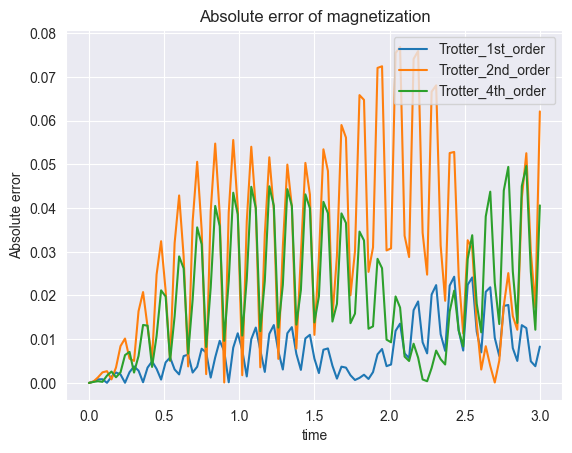

In [32]:
# Check the absolute error
plt.xlabel("time")
plt.ylabel("Absolute error")
plt.title("Absolute error of magnetization")
plt.plot(x, np.abs(np.array(y_trotter_1) - np.array(y_exact)), label="Trotter_1st_order")
plt.plot(x, np.abs(np.array(y_trotter_2) - np.array(y_exact)), label="Trotter_2nd_order")
plt.plot(x, np.abs(np.array(y_trotter_4) - np.array(y_exact)), label="Trotter_4th_order")
plt.legend(loc='upper right')
plt.show()

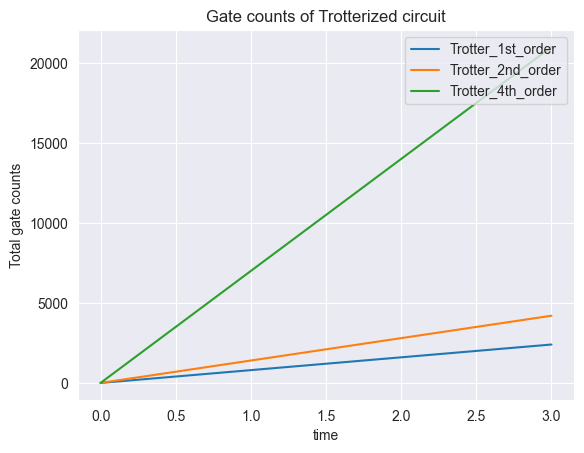

In [33]:
# Compare the gate counts
plt.xlabel("time")
plt.ylabel("Total gate counts")
plt.title("Gate counts of Trotterized circuit")
plt.plot(x, [circuit_trotter_transIsing_1.get_gate_count() * i for i in range(M + 1)], label="Trotter_1st_order")
plt.plot(x, [circuit_trotter_transIsing_2.get_gate_count() * i for i in range(M + 1)], label="Trotter_2nd_order")
plt.plot(x, [circuit_trotter_transIsing_4.get_gate_count() * i for i in range(M + 1)], label="Trotter_4th_order")
plt.legend(loc="upper right")
plt.show()